# Plotting PPO agent with dietkit data

In [1]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from meal_planning_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


In [2]:
all_ingredients = load_ingredient(sample_language = 'eng')
meal_dict = load_menu(ingredients = all_ingredients, sample_language = 'eng')
example_mealplans = load_diet(menus = meal_dict, num_loads = 100, sample_language = 'eng', sample_name = 'ML')

possible_meals = np.array(list(meal_dict.keys()))

nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)
nutrition_data = nutrition_data.tail(10)
possible_meals = possible_meals[-10:]
display(possible_meals)
display(nutrition_data)



array(['Winter cabbage kimchi', 'Young radish kimchi',
       'Young radish water kimchi', 'Pickled cucumber', 'Cucumber kimchi',
       'Ponytail radish kimchi', 'Kohlrabi watery kimchi',
       'Green onion kimchi', 'Pickled paprika', 'empty'], dtype='<U72')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
Winter cabbage kimchi,7.50,0.4700,0.14500,1.0925,0.825,31.250,0.09750,145.250,28.666667,0.004000,0.00975,1.3400,64.3175,17.8000
Young radish kimchi,8.00,0.6000,0.07250,1.2475,0.800,33.500,0.17000,127.500,18.291667,0.007000,0.04425,0.4000,27.9875,16.7475
Young radish water kimchi,5.40,0.4230,0.02100,0.8730,0.150,9.600,0.06300,147.900,9.450000,0.008400,0.01230,1.1640,10.3770,2.2020
Pickled cucumber,22.75,0.0950,0.03000,6.2675,0.525,12.750,0.06250,260.000,2.937500,0.004000,0.00250,0.0000,6.1675,8.3500
Cucumber kimchi,11.10,0.5280,0.11100,1.9980,0.930,8.700,0.17100,90.600,16.825000,0.023100,0.02970,0.2670,59.6010,11.3790
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448
empty,0.00,0.0000,0.00000,0.0000,0.000,0.000,0.00000,0.000,0.000000,0.000000,0.00000,0.0000,0.0000,0.0000


In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 2
Chosen Meal: Winter cabbage kimchi
Meal History: ['Pickled cucumber' 'Winter cabbage kimchi']
Nutrition History: [[2.2750e+01 1.0000e-01 3.0000e-02 6.2700e+00 5.2000e-01 1.2750e+01
  6.0000e-02 2.6000e+02 2.9400e+00 0.0000e+00 0.0000e+00 0.0000e+00
  6.1700e+00 8.3500e+00]
 [7.5000e+00 4.7000e-01 1.4000e-01 1.0900e+00 8.2000e-01 3.1250e+01
  1.0000e-01 1.4525e+02 2.8670e+01 0.0000e+00 1.0000e-02 1.3400e+00
  6.4320e+01 1.7800e+01]]
Goal Nutrition: [1.8140e+01 7.5000e-01 1.2000e-01 3.7700e+00 1.2200e+00 2.6700e+01
 2.1000e-01 2.3539e+02 2.2730e+01 5.0000e-02 4.0000e-02 5.6800e+00
 5.6470e+01 1.8950e+01]
Current Nutrition: [3.0250e+01 5.6000e-01 1.8000e-01 7.3600e+00 1.3500e+00 4.4000e+01
 1.6000e-01 4.0525e+02 3.1600e+01 1.0000e-02 1.0000e-02 1.3400e+00
 7.0480e+01 2.6150e+01]
Reward: 618.7094166750002
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 608.66
Saving new best model to ./tmp/gym/best_model

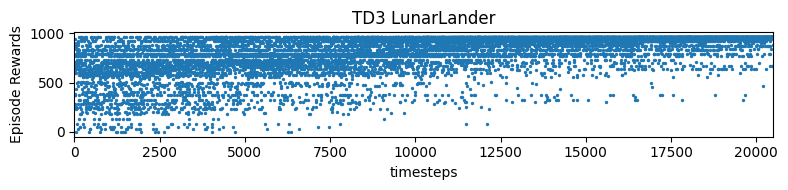

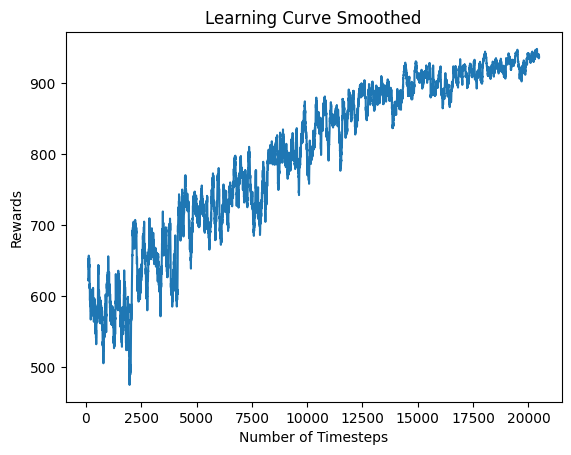

In [4]:
num_meals = 2
env = MealPlanningEnv(possible_meals=possible_meals, nutrition_data=nutrition_data, num_meals=num_meals)

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()
model.learn(total_timesteps=20000, callback=callback)

obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  action, _states = model.predict(obs)
  # print(action)
  
 
env.render()

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

plot_results(log_dir)